In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
EN_LEN = 100
DEC_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

In [ ]:
# !python -m wget 'https://storage.googleapis.com/samanantar-public/V0.2/data/en2indic/en-mr.zip'
# !python -m wget 'https://storage.googleapis.com/samanantar-public/V0.2/data/en2indic/en-hi.zip'

In [ ]:
# !unzip en-hi.zip

In [ ]:
# f = open(trainfileEH, "r")
# EnglishV = f.readlines()
# f.close()
# EnglishV = removeNewLineChars(EnglishV)
# print(f"Total English Sentences : {len(EnglishV)}")

In [ ]:
# f = open(trainfileEH, "r")
# HindiV = f.readlines()
# f.close()
# HindiV = removeNewLineChars(HindiV)
# print(f"Total Hindi Sentences : {len(EnglishV)}")

In [ ]:
# train_df = pd.DataFrame(list(zip(EnglishV, HindiV)), columns=["english_sentence", 'hindi_sentence'])

In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/saurabhburewar/ML_English-to-Hindi-Language-translation/main/data/Hindi_English_Truncated_Corpus.csv")
train_df.drop(['source'],axis=1,inplace=True)
for index, row in train_df.iterrows():
  if len(str(row['english_sentence'])) < 20 and len(str(row['english_sentence'])) > 200:
    train_df.drop(index=index, inplace=True)
  else:
    row['english_sentence'] = "<SOS> " + str(row['english_sentence']) + " <EOS>"
    row['hindi_sentence'] = "<SOS> " + row['hindi_sentence'] + " <EOS>"
train_df = train_df.sample(64000, random_state=1)
train_df.head()

,english_sentence,hindi_sentence
73642,<SOS> And all you can think about is that oppo...,<SOS> और आप एक ही बात सोच रहे होते हैं कि सुधा...
81218,"<SOS> She has got awards from administrative, ...",<SOS> उन्हें प्रशासनिक अर्धप्रशासनिक और व्यक्त...
19190,<SOS> The member whose question has been admit...,<SOS> प्रश्न किस प्रकार पूछे जाते हैं जिस सदस्...
73887,<SOS> 7 . We will consider your application ca...,<SOS> 7 हम आप के आवेदन पत्र पर वर्क परमिट के द...
67379,<SOS> Class: Nobel Prize Recepient <EOS>,<SOS> श्रेणी:नोबेल पुरस्कार सम्मानित <EOS>


In [ ]:
tokenizerEng = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<unk>')
tokenizerHindi = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<unk>')
tokenizerEng.fit_on_texts(train_df['english_sentence'])
tokenizerHindi.fit_on_texts(train_df['hindi_sentence'])

input = tokenizerEng.texts_to_sequences(train_df['english_sentence'])
target = tokenizerHindi.texts_to_sequences(train_df['hindi_sentence'])

In [ ]:
vocabEnc = len(tokenizerEng.word_index) + 1
vocabDec = len(tokenizerHindi.word_index) + 1
print(vocabEnc, vocabDec)

47585 56905


In [ ]:
input = tf.keras.preprocessing.sequence.pad_sequences(input, maxlen=EN_LEN, padding='post', truncating='post')
target = tf.keras.preprocessing.sequence.pad_sequences(target, maxlen=DEC_LEN, padding='post', truncating='post')
input = tf.cast(input, dtype=tf.int64)
target = tf.cast(target, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input, target)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def positional_encoding(position, model):
    i = np.arange(model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(model))
    angle_rads = np.arange(position)[:, np.newaxis] * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = []
        for _ in range(num_layers):
          self.enc_layers.append(EncoderLayer(d_model, num_heads, dff, rate))

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = []
        for _ in range(num_layers):
          self.dec_layers.append(DecoderLayer(d_model, num_heads, dff, rate))

        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        # attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
    
        return x
    

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 10

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step), (step * (self.warmup_steps ** -1.5)))

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

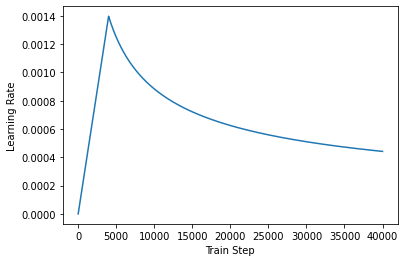

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)
print(temp_learning_rate_schedule)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocabEnc,
    target_vocab_size=vocabDec,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_target_padding_mask = create_padding_mask(tar_inp)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    with tf.GradientTape() as tape:
        predictions = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
def evaluate(text):
    text = tokenizerEng.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=EN_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [tokenizerHindi.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DEC_LEN):
        enc_padding_mask = create_padding_mask(encoder_input)
        dec_padding_mask = create_padding_mask(encoder_input)

        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        dec_target_padding_mask = create_padding_mask(output)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        predictions = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == tokenizerHindi.word_index['<eos>']:
            return tf.squeeze(output, axis=0)

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [ ]:
def translator(eng_text):
    hind_text = evaluate(eng_text).numpy()
    hind_text = np.expand_dims(hind_text[1:], 0)  
    return tokenizerHindi.sequences_to_texts(hind_text)[0]

In [ ]:
translator("That politics , in retrospect , was rooted in a false ideology")

In [ ]:
texts = ["I spend a few hours a day maintaining my website.",
        "Where do random thoughts come from?",
        "	I can't believe that she is older than my mother.",
        "My Mum tries to be cool by saying that she likes all the same things that I do",
        "A song can make or ruin a person’s day if they let it get to them."]

for text in texts:
  print("English Text: ", text)
  print("Hindi Translation: ", translator(text))
  print("*"*50,"\n")

In [ ]:
texts = ["And who are we to say, even, that they are wrong",
        "So there is some sort of justice",
        "The first two were found unreliable and the prosecution case rested mainly on the evidence of the remaining five approvers",
        "Naren had three or four meetings with the Consul but found that he was making no progress",
        "Of these Lahadi is a popular one ."]

for text in texts:
  print("English Text: ", text)
  print("Hindi Translation: ", translator(text))
  print("*"*50,"\n")